In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [3]:
cols = ['Gender' , 'Married' , 'Dependents' , 'Education' , 'Self_Employed' , 'ApplicantIncome' , 'CoapplicantIncome' , 'LoanAmount' , 'Loan_Amount_Term' , 'Credit_History' , 'Property_Area']
df = pd.read_csv('train.csv')

In [4]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [5]:
df = df.drop('Loan_ID', axis=1)

df['Dependents'] = df['Dependents'].replace('3+', 3)
df['Dependents'] = df['Dependents'].fillna(0)
df['Dependents'] = df['Dependents'].astype(int)

df['LoanAmount'] = df['LoanAmount'].fillna(round(df['LoanAmount'].mean()))

df['Loan_Amount_Term'] = df['Loan_Amount_Term'].fillna(round(df['Loan_Amount_Term'].mean()))
df['Credit_History'] = df['Credit_History'].fillna(round(df['Credit_History'].mean()))
df['Gender'].fillna(df['Gender'].mode()[0], inplace=True)

df['Loan_Status'] = (df['Loan_Status']=='Y').astype(int)
df['Gender'] = (df['Gender']=='Male').astype(int)
df['Married'] = (df['Married']=='Yes').astype(int)
df['Education'] = (df['Education']=='Graduate').astype(int)
df['Self_Employed'] = (df['Self_Employed']=='Yes').astype(int)
df['Property_Area'] = df['Property_Area'].map({
    'Urban': 1,
    'Semiurban': 2,
    'Rural': 3
})

/var/folders/x2/l_5d0d0s0vl8qyysbj30klgr0000gn/T/ipykernel_37689/861233013.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Gender'].fillna(df['Gender'].mode()[0], inplace=True)


In [6]:
df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,1,0,0,1,0,5849,0.0,146.0,360.0,1.0,1,1
1,1,1,1,1,0,4583,1508.0,128.0,360.0,1.0,3,0
2,1,1,0,1,1,3000,0.0,66.0,360.0,1.0,1,1
3,1,1,0,0,0,2583,2358.0,120.0,360.0,1.0,1,1
4,1,0,0,1,0,6000,0.0,141.0,360.0,1.0,1,1


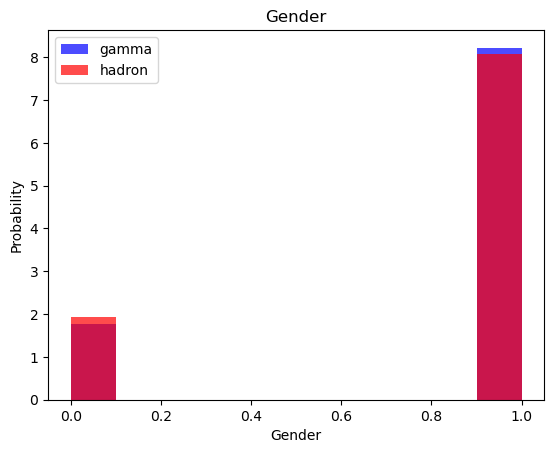

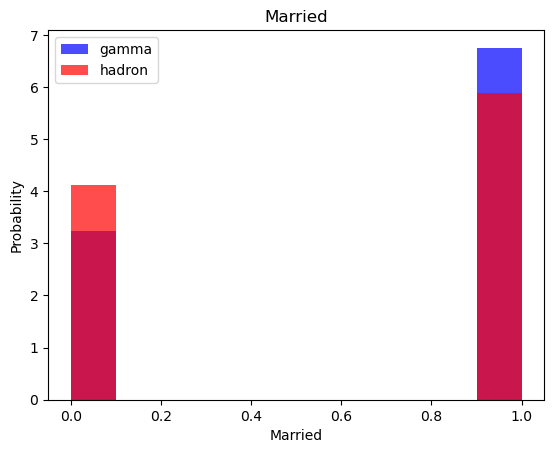

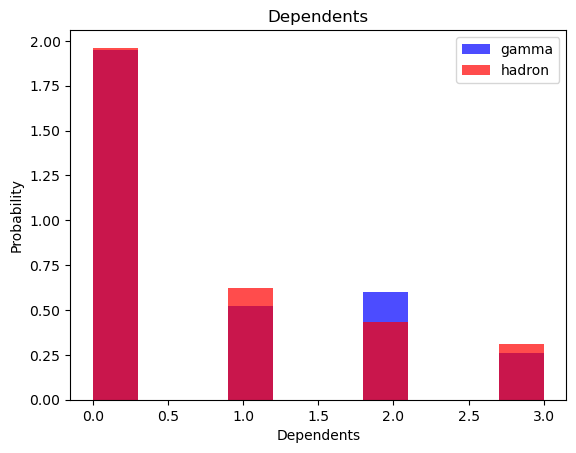

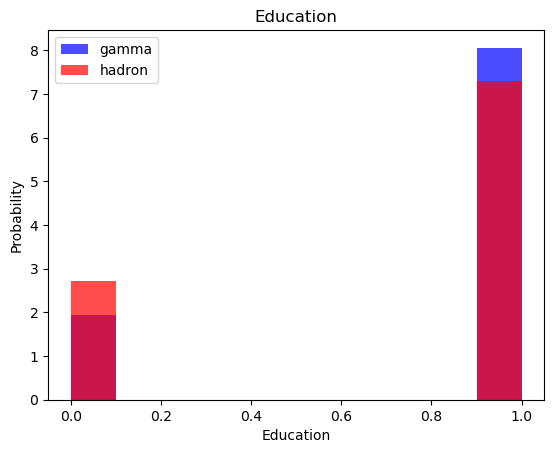

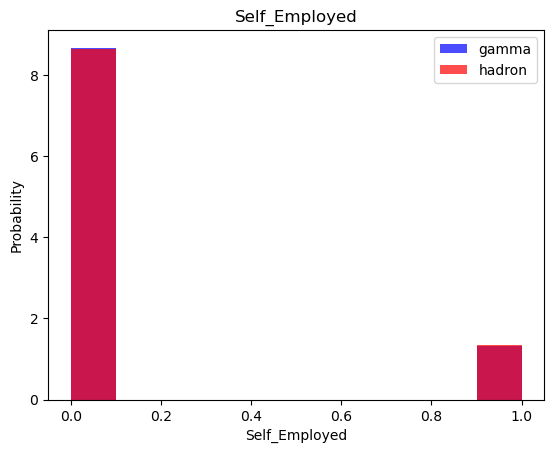

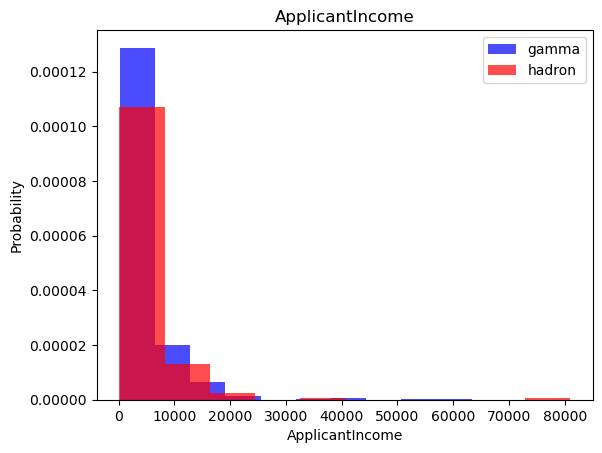

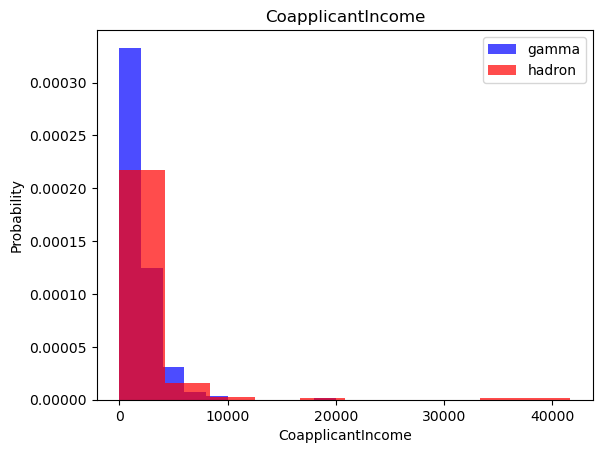

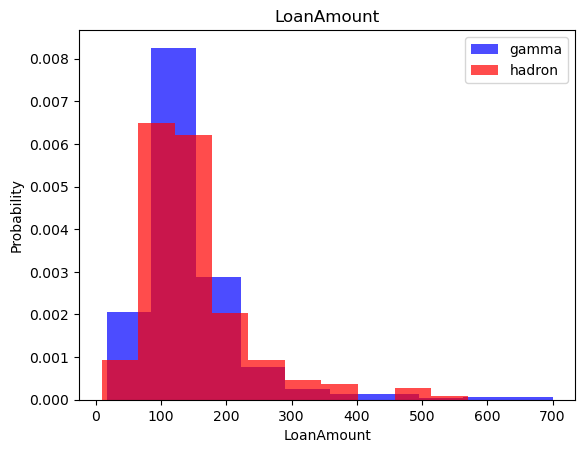

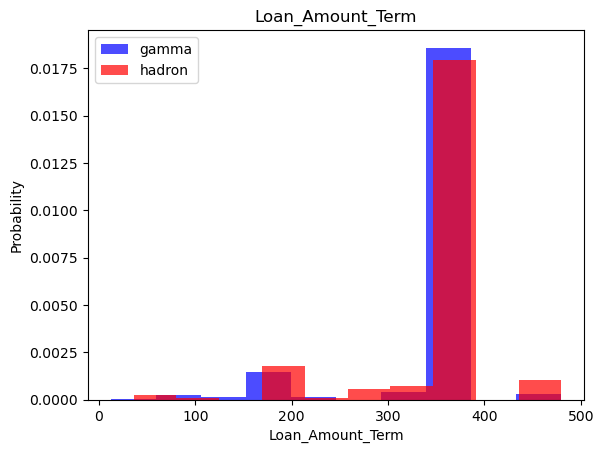

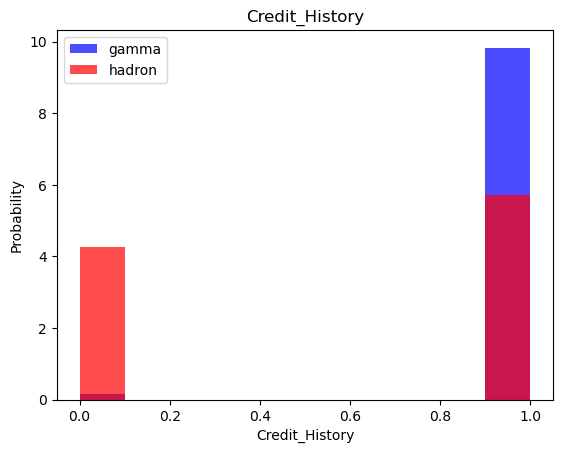

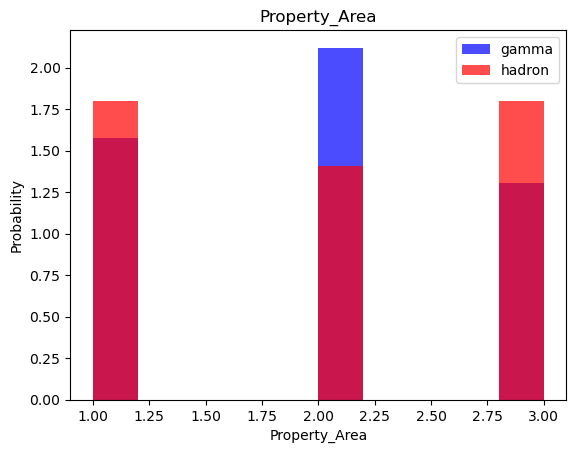

In [7]:
cols = df.columns.tolist()
for label in cols[:-1]:
  plt.hist(df[df['Loan_Status']==1][label],color ='blue',alpha=0.7,density=True,label='gamma')
  plt.hist(df[df['Loan_Status']==0][label],color ='red',alpha=0.7,density=True,label='hadron')
  plt.title(label)
  plt.ylabel('Probability')
  plt.xlabel(label)
  plt.legend()
  plt.show()

In [8]:
train , valid, test = np.split(df.sample(frac=1), [int(0.6*len(df)) , int(0.8*len(df))])
# train , valid = np.split(df.sample(frac=1), [int(0.8*len(df))])

/opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [9]:
print(train.shape)
print(valid.shape)
print(test.shape)

(368, 12)
(123, 12)
(123, 12)


In [10]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
def scale_dataset(dataframe , oversample = False):
  x = dataframe[dataframe.columns[:-1]].values
  y = dataframe[dataframe.columns[-1]].values

  scaler = StandardScaler()
  x = scaler.fit_transform(x)

  if oversample :
    ros = RandomOverSampler()
    x , y = ros.fit_resample(x,y)

  data = np.hstack((x,np.reshape(y,(-1,1))))

  return data, x, y

In [11]:
train, x_train, y_train = scale_dataset(train, oversample=True)
valid, x_valid, y_valid = scale_dataset(valid, oversample=False)
test, x_test, y_test = scale_dataset(test, oversample=False)

In [12]:
print([train.shape,x_train.shape,y_train.shape])
print([valid.shape,x_valid.shape,y_valid.shape])
print([test.shape,x_test.shape,y_test.shape])

[(518, 12), (518, 11), (518,)]
[(123, 12), (123, 11), (123,)]
[(123, 12), (123, 11), (123,)]


In [13]:
def train_model(x_train, y_train, num_nodes, dropout_prob, lr, batch_size, epochs):
  nn_model = tf.keras.Sequential([
    tf.keras.layers.Dense(num_nodes , activation='relu', input_shape=(11,)),
    tf.keras.layers.Dropout(dropout_prob),
    tf.keras.layers.Dense(num_nodes , activation='relu'),
    tf.keras.layers.Dense(1 , activation='sigmoid')
  ])

  nn_model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='binary_crossentropy',
                  metrics=['accuracy'])
  history = nn_model.fit(
    x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=0
  )
  return nn_model, history

In [14]:
def plot_history(history):
  fig, (ax1 , ax2) = plt.subplots(1,2 , figsize=(8,4))
  ax1.plot(history.history['loss'],label='loss')
  ax1.plot(history.history['val_loss'],label='val_loss')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Binary crossentropy')
  ax2.plot(history.history['accuracy'],label='accuracy')
  ax2.plot(history.history['val_accuracy'],label='val_accuracy')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Accuracy')
  ax1.grid(True)
  plt.show()

16 nodes , dropout 0, lr 0.1, batch size 32


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


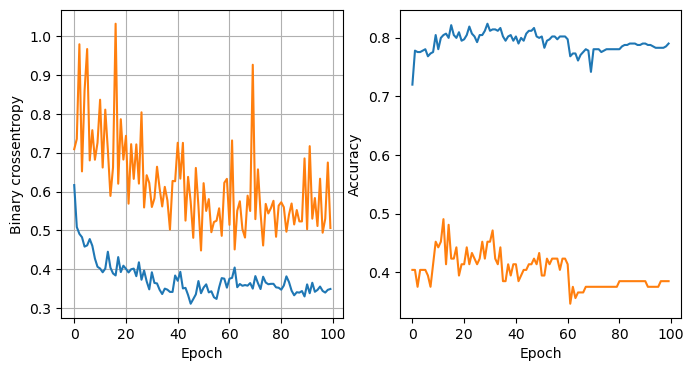

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7311 - loss: 5.4134
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
16 nodes , dropout 0, lr 0.1, batch size 64


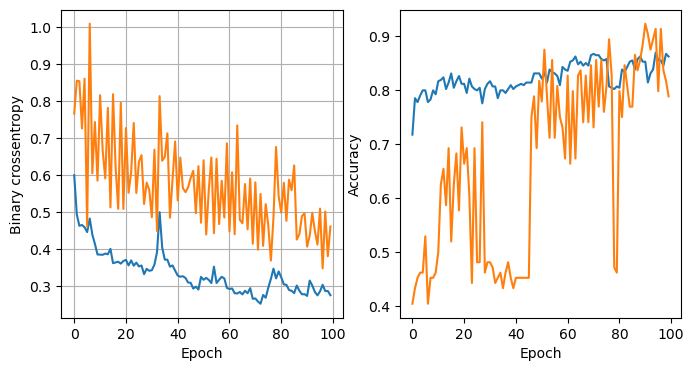

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6852 - loss: 2.8833  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
16 nodes , dropout 0, lr 0.1, batch size 128


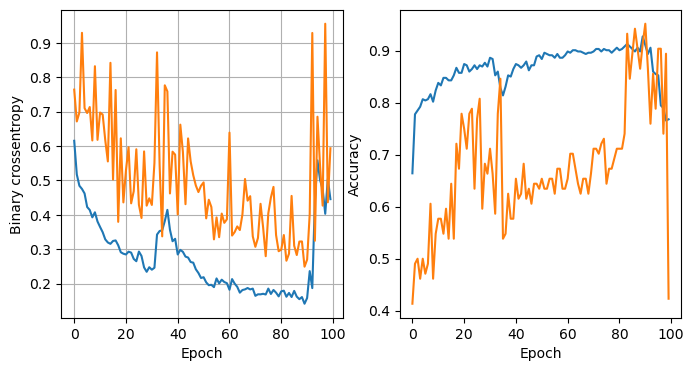

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7078 - loss: 1.9004  
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x31dbead40> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
16 nodes , dropout 0, lr 0.005, batch size 32


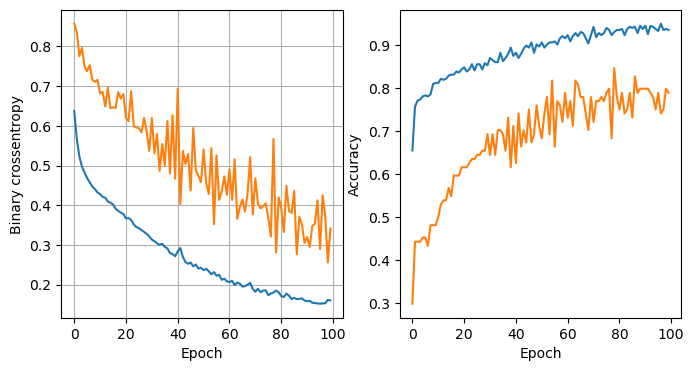

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6961 - loss: 1.4929
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
16 nodes , dropout 0, lr 0.005, batch size 64


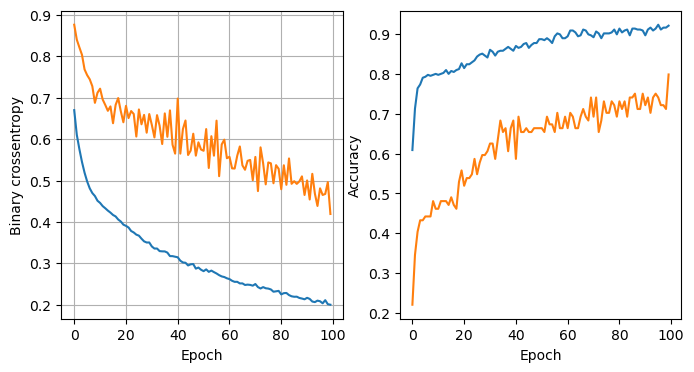

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7424 - loss: 1.3039  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
16 nodes , dropout 0, lr 0.005, batch size 128


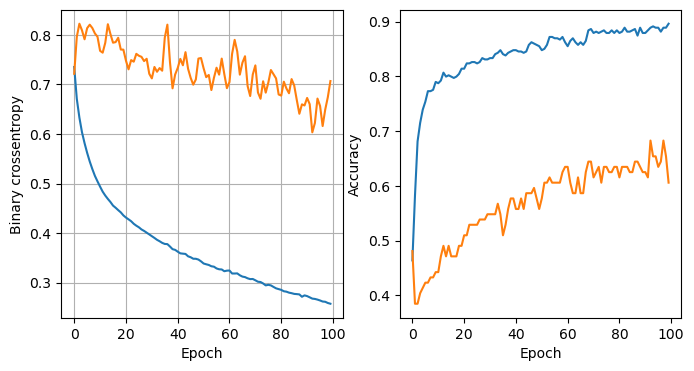

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7500 - loss: 0.7438
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
16 nodes , dropout 0, lr 0.001, batch size 32


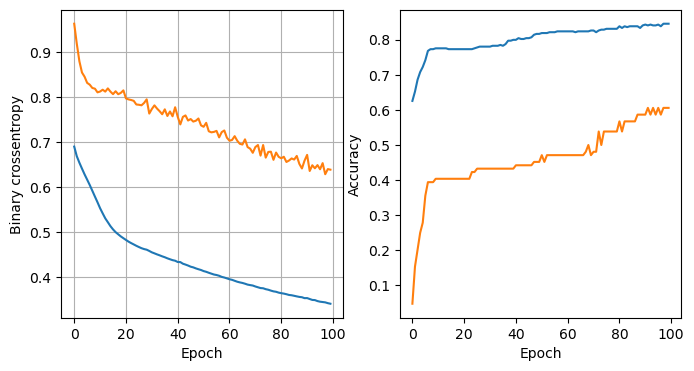

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7659 - loss: 0.6578
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
16 nodes , dropout 0, lr 0.001, batch size 64


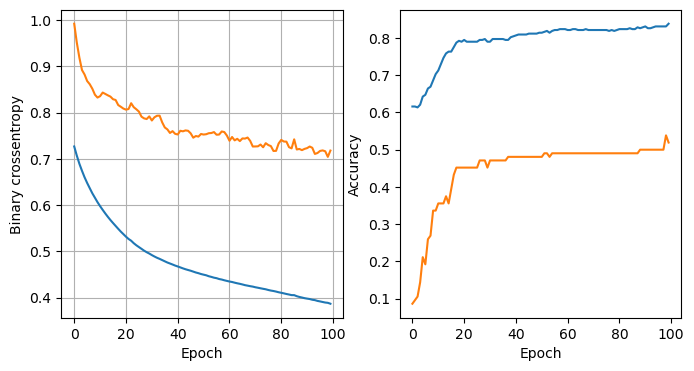

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7743 - loss: 0.5633  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
16 nodes , dropout 0, lr 0.001, batch size 128


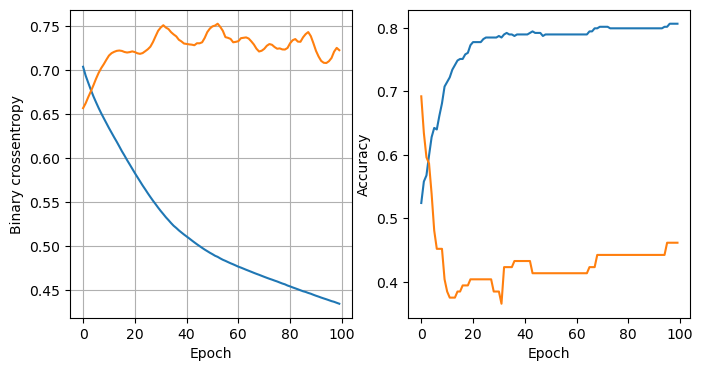

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7776 - loss: 0.5610
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
16 nodes , dropout 0.2, lr 0.1, batch size 32


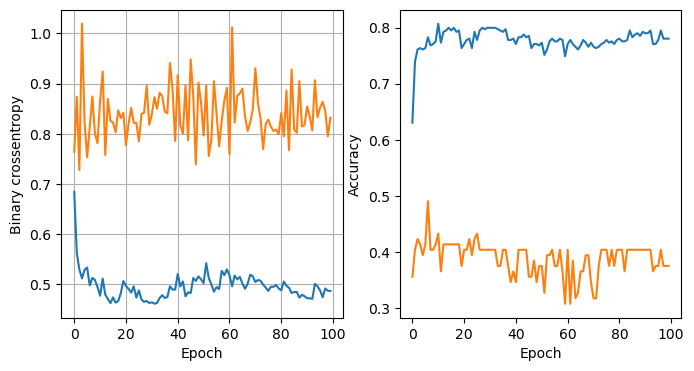

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7311 - loss: 1.5035  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
16 nodes , dropout 0.2, lr 0.1, batch size 64


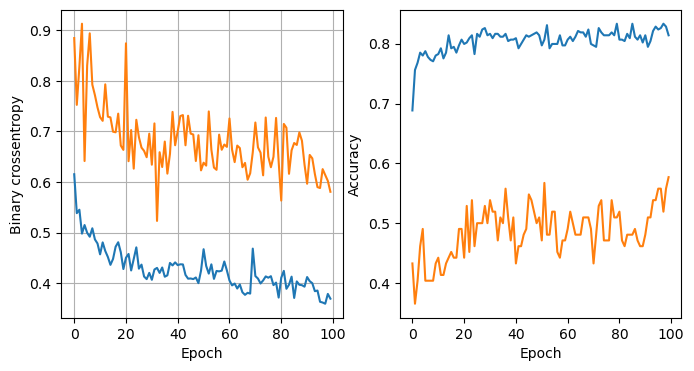

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7426 - loss: 2.3803  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
16 nodes , dropout 0.2, lr 0.1, batch size 128


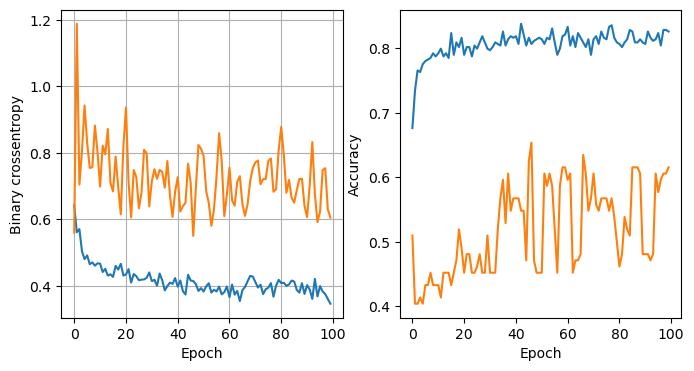

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7293 - loss: 0.9602
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
16 nodes , dropout 0.2, lr 0.005, batch size 32


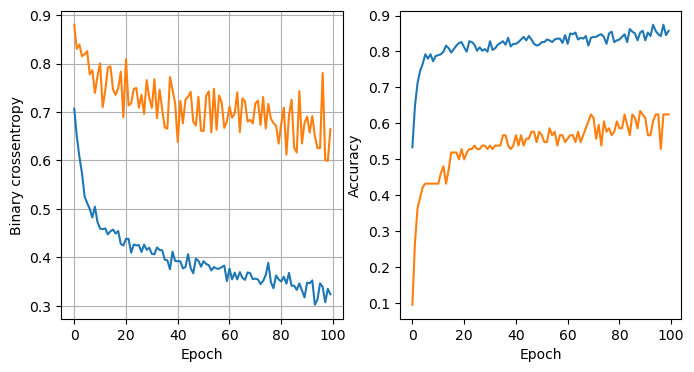

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7574 - loss: 0.8137  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
16 nodes , dropout 0.2, lr 0.005, batch size 64


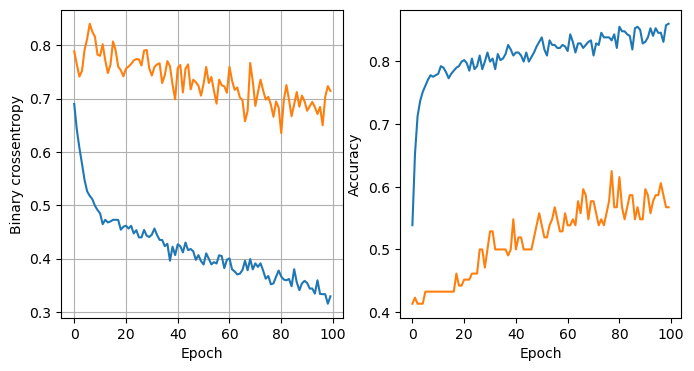

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7722 - loss: 0.7308
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
16 nodes , dropout 0.2, lr 0.005, batch size 128


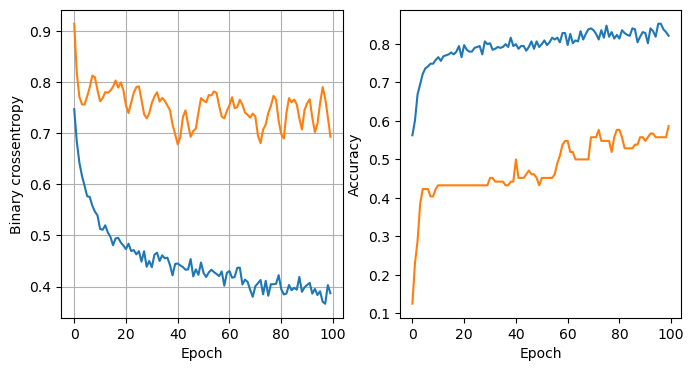

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7711 - loss: 0.6302
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
16 nodes , dropout 0.2, lr 0.001, batch size 32


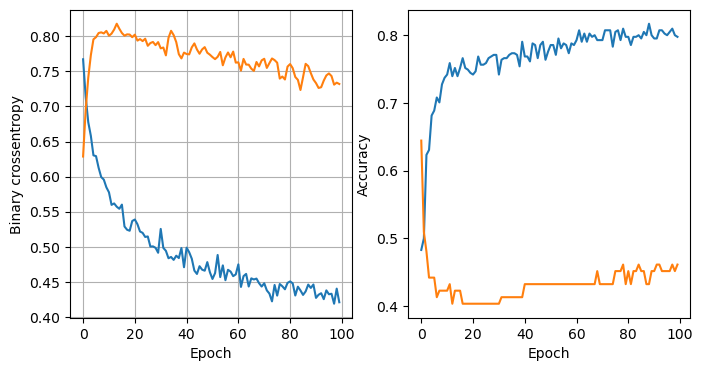

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7657 - loss: 0.5982
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
16 nodes , dropout 0.2, lr 0.001, batch size 64


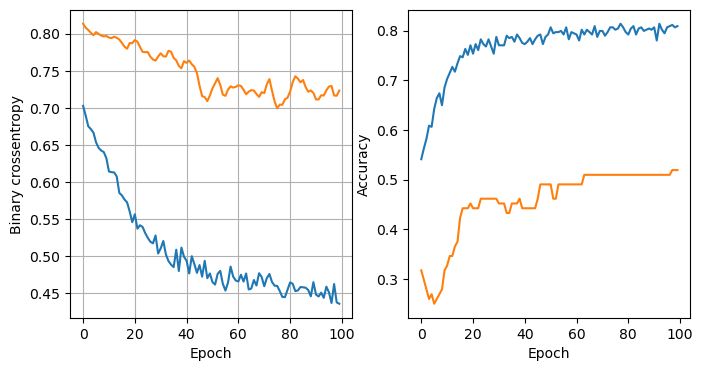

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7396 - loss: 0.5399
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
16 nodes , dropout 0.2, lr 0.001, batch size 128


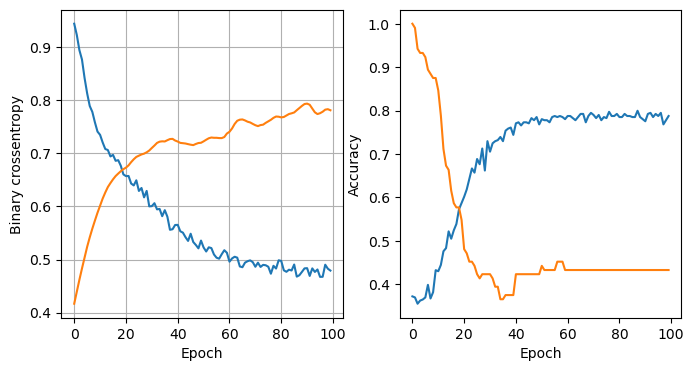

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7743 - loss: 0.5705
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
32 nodes , dropout 0, lr 0.1, batch size 32


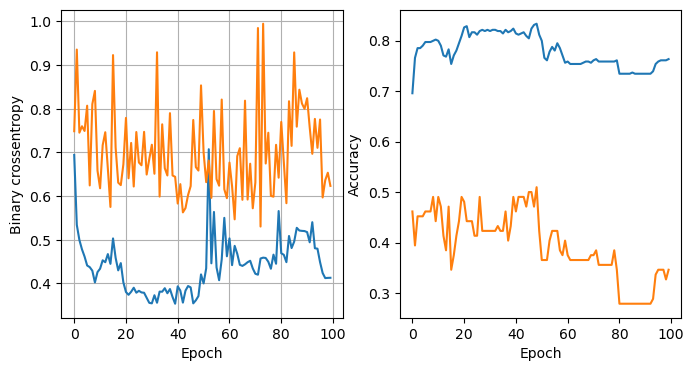

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7311 - loss: 4.0719  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
32 nodes , dropout 0, lr 0.1, batch size 64


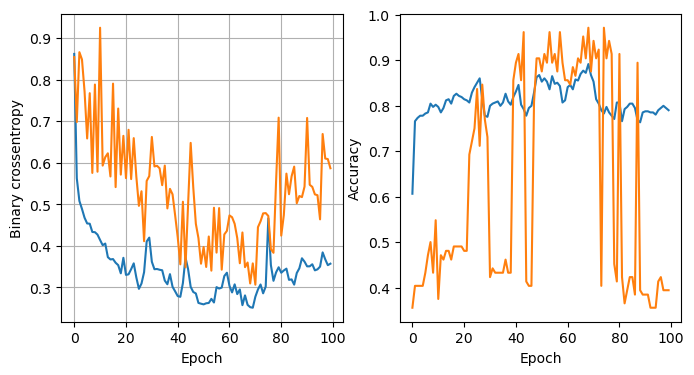

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7310 - loss: 2.3819  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
32 nodes , dropout 0, lr 0.1, batch size 128


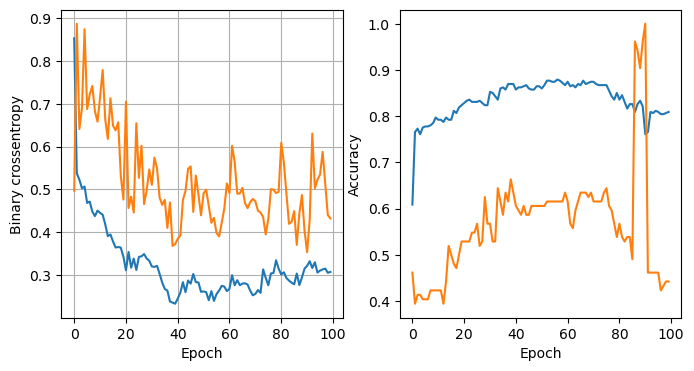

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7457 - loss: 2.9991
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
32 nodes , dropout 0, lr 0.005, batch size 32


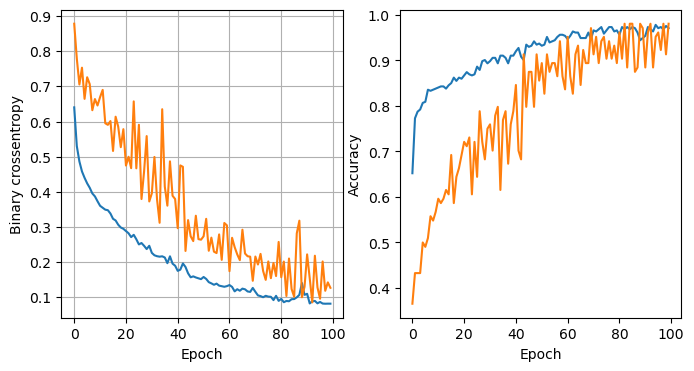

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7190 - loss: 2.1402
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
32 nodes , dropout 0, lr 0.005, batch size 64


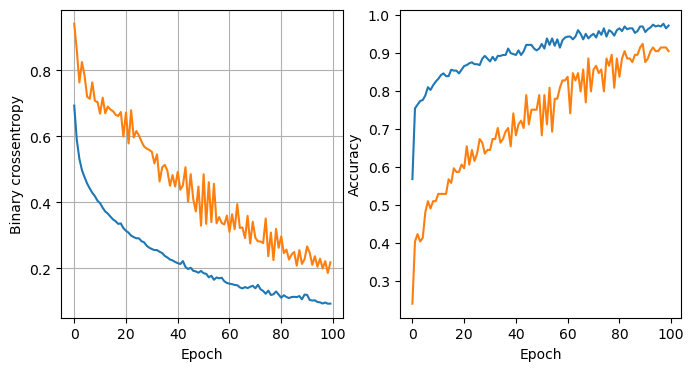

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7466 - loss: 2.1167
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
32 nodes , dropout 0, lr 0.005, batch size 128


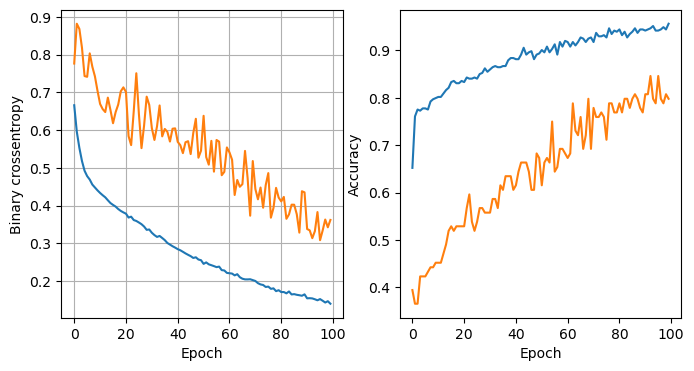

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7582 - loss: 1.5295
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
32 nodes , dropout 0, lr 0.001, batch size 32


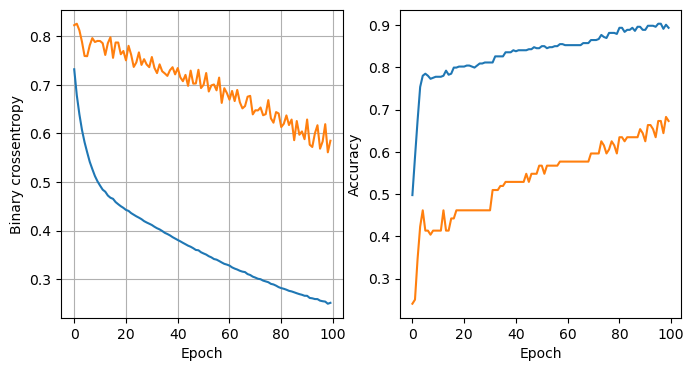

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7890 - loss: 0.7598
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
32 nodes , dropout 0, lr 0.001, batch size 64


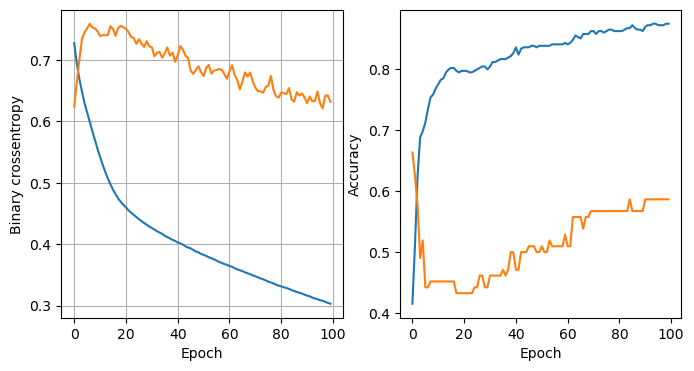

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7837 - loss: 0.7145
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
32 nodes , dropout 0, lr 0.001, batch size 128


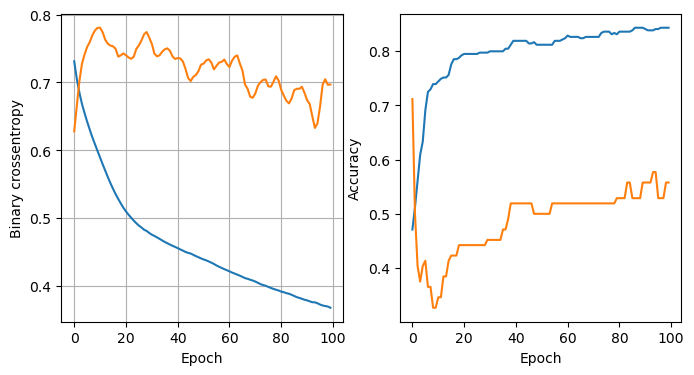

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7975 - loss: 0.5482
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
32 nodes , dropout 0.2, lr 0.1, batch size 32


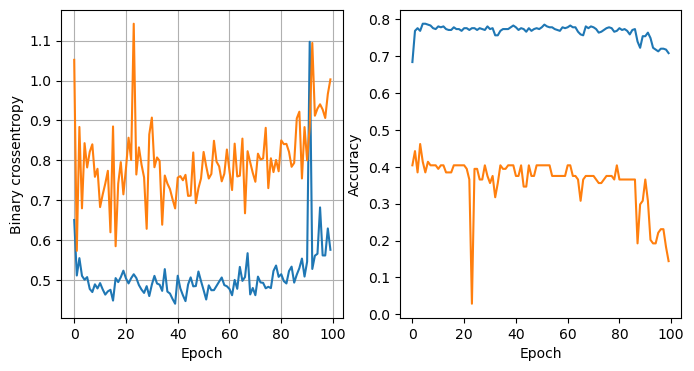

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7056 - loss: 2.6048
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
32 nodes , dropout 0.2, lr 0.1, batch size 64


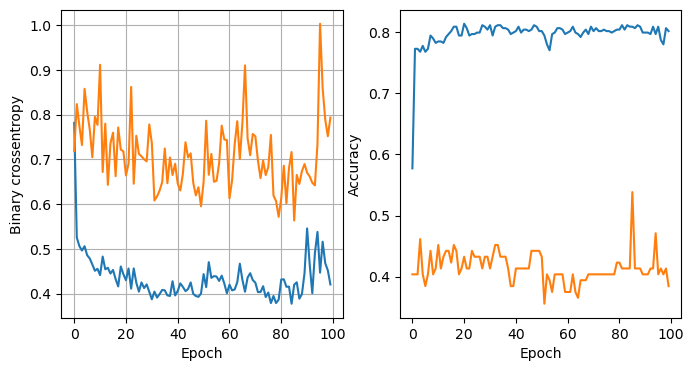

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7458 - loss: 2.0174
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
32 nodes , dropout 0.2, lr 0.1, batch size 128


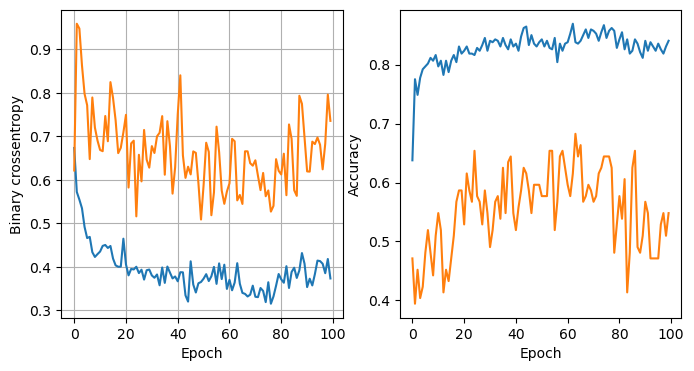

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7320 - loss: 0.9329  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
32 nodes , dropout 0.2, lr 0.005, batch size 32


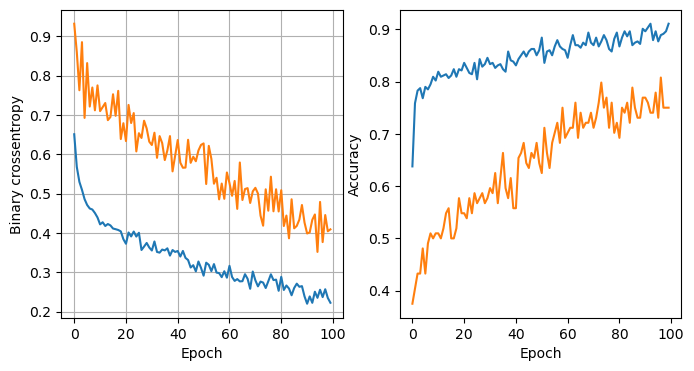

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7381 - loss: 0.8957  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
32 nodes , dropout 0.2, lr 0.005, batch size 64


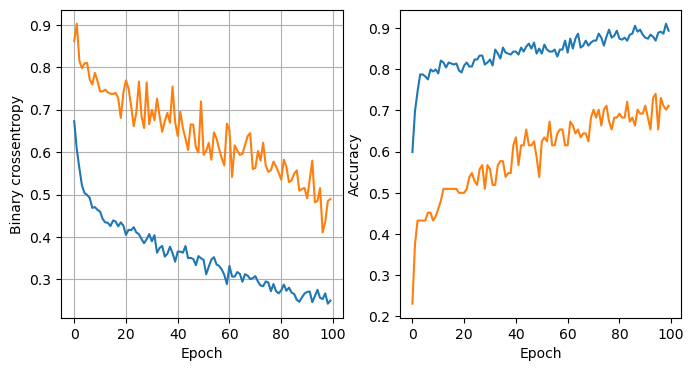

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7743 - loss: 0.8923  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
32 nodes , dropout 0.2, lr 0.005, batch size 128


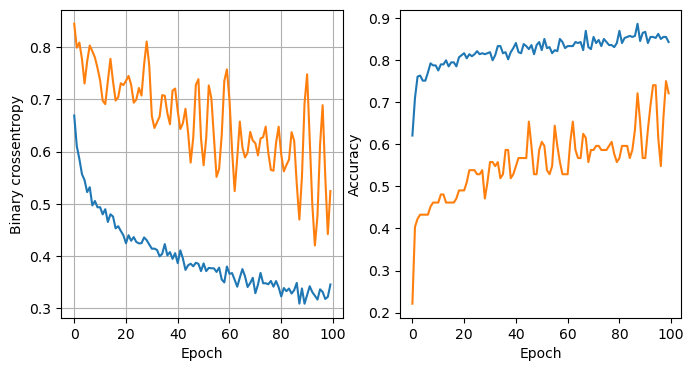

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7730 - loss: 0.7669
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
32 nodes , dropout 0.2, lr 0.001, batch size 32


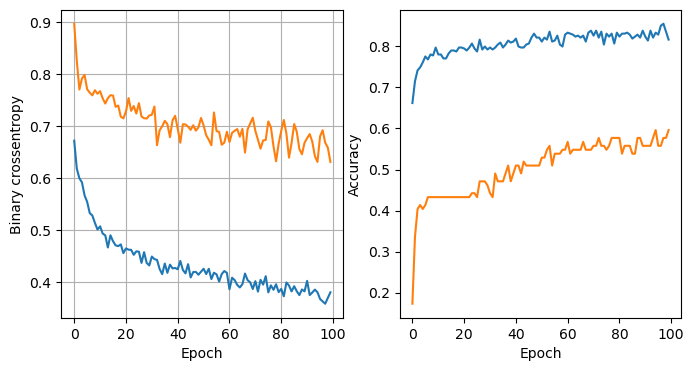

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7742 - loss: 0.6137
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
32 nodes , dropout 0.2, lr 0.001, batch size 64


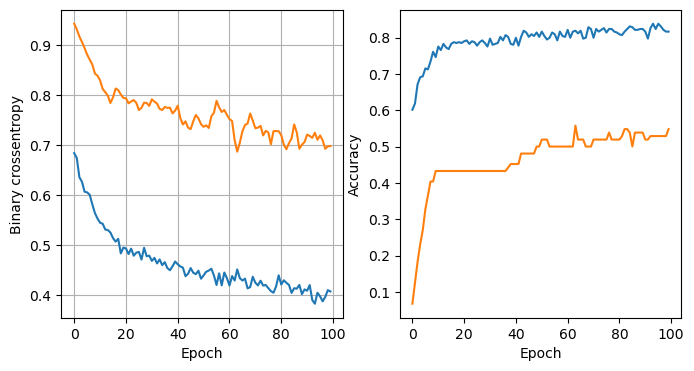

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7816 - loss: 0.5817  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
32 nodes , dropout 0.2, lr 0.001, batch size 128


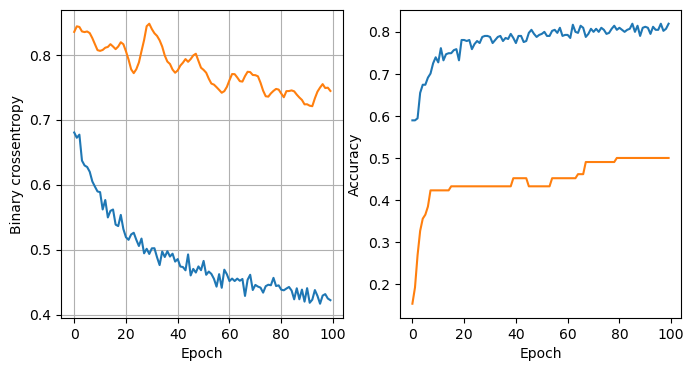

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7837 - loss: 0.5827
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
64 nodes , dropout 0, lr 0.1, batch size 32


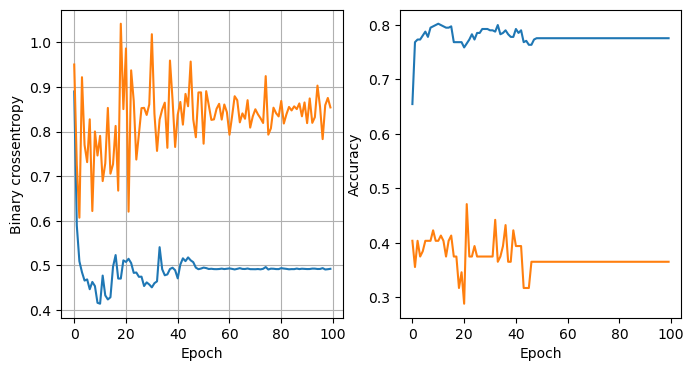

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7278 - loss: 1.5634
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  
64 nodes , dropout 0, lr 0.1, batch size 64


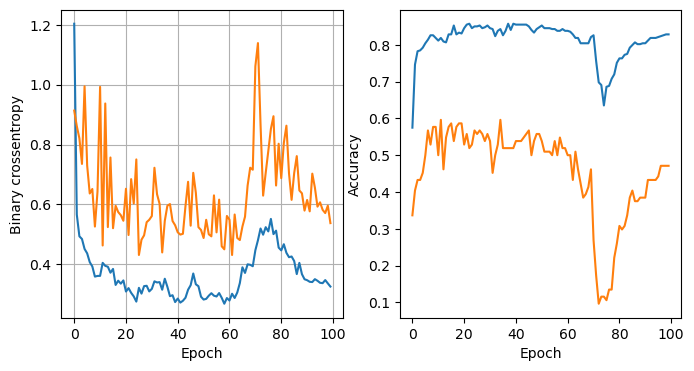

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7596 - loss: 1.7465
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
64 nodes , dropout 0, lr 0.1, batch size 128


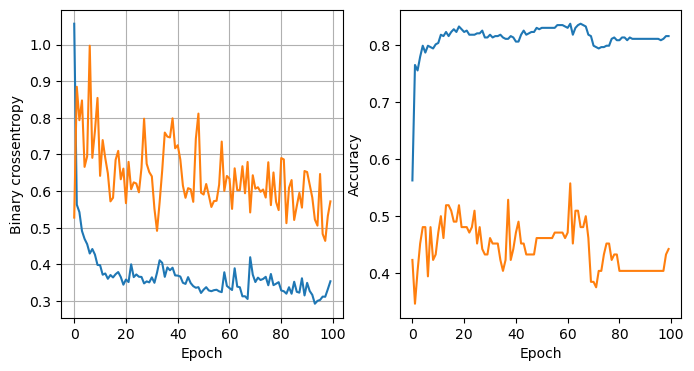

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7436 - loss: 1.7179  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
64 nodes , dropout 0, lr 0.005, batch size 32


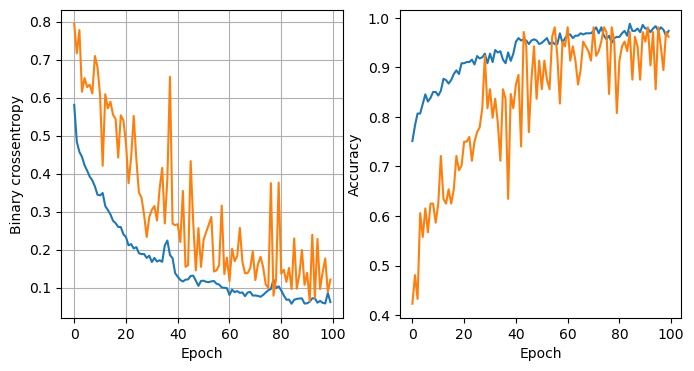

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7368 - loss: 2.4479
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
64 nodes , dropout 0, lr 0.005, batch size 64


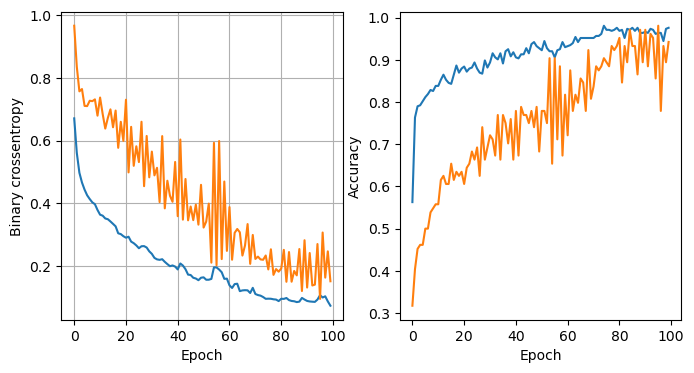

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7319 - loss: 1.9400  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
64 nodes , dropout 0, lr 0.005, batch size 128


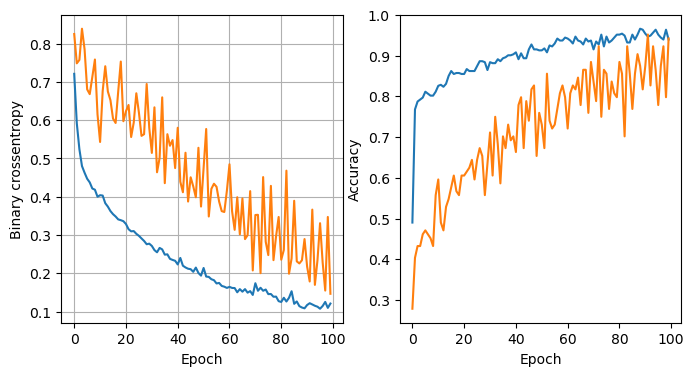

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7233 - loss: 1.6826
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
64 nodes , dropout 0, lr 0.001, batch size 32


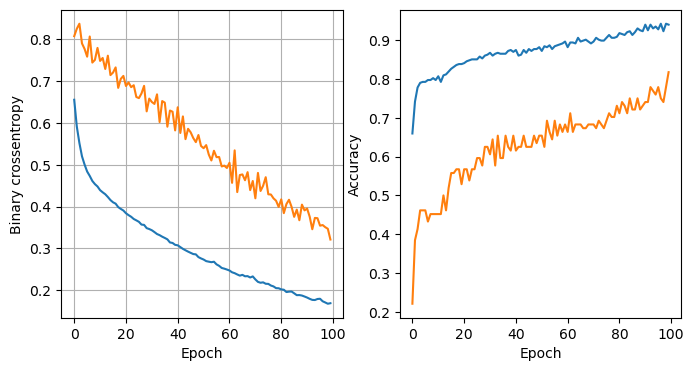

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7340 - loss: 1.1119  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
64 nodes , dropout 0, lr 0.001, batch size 64


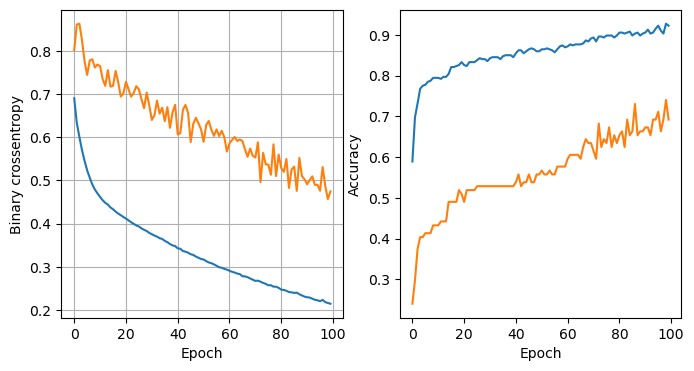

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7583 - loss: 0.8000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  
64 nodes , dropout 0, lr 0.001, batch size 128


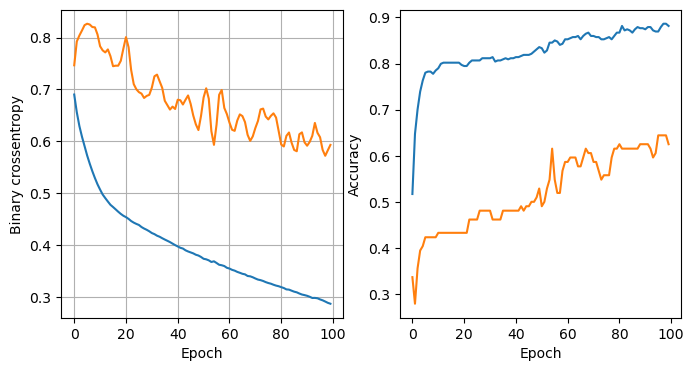

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7773 - loss: 0.7593
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
64 nodes , dropout 0.2, lr 0.1, batch size 32


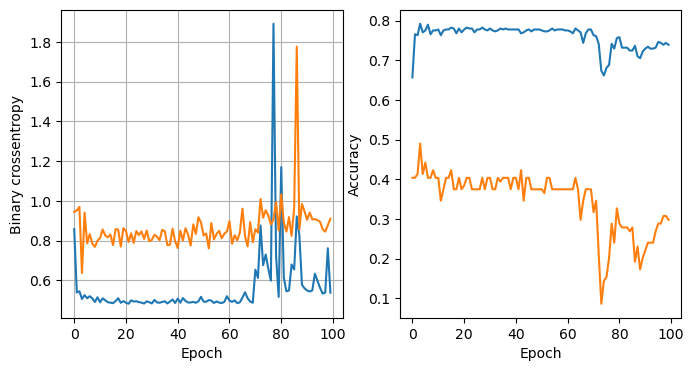

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7225 - loss: 12.4637
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
64 nodes , dropout 0.2, lr 0.1, batch size 64


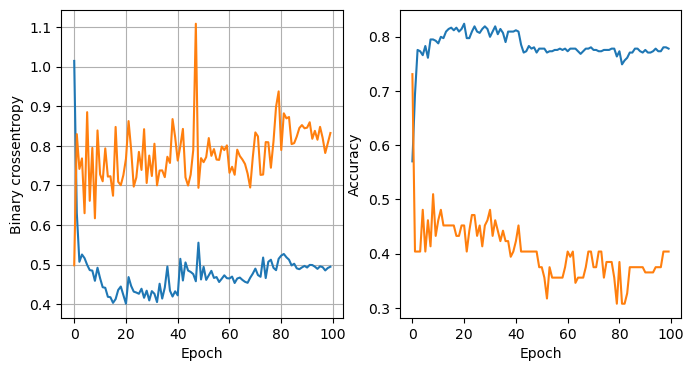

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7311 - loss: 2.0959
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
64 nodes , dropout 0.2, lr 0.1, batch size 128


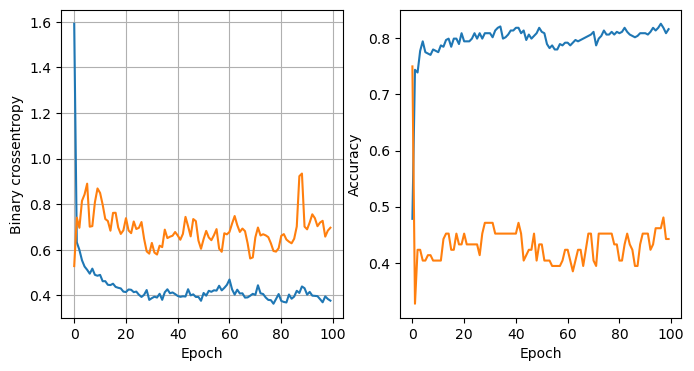

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7596 - loss: 1.0521
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
64 nodes , dropout 0.2, lr 0.005, batch size 32


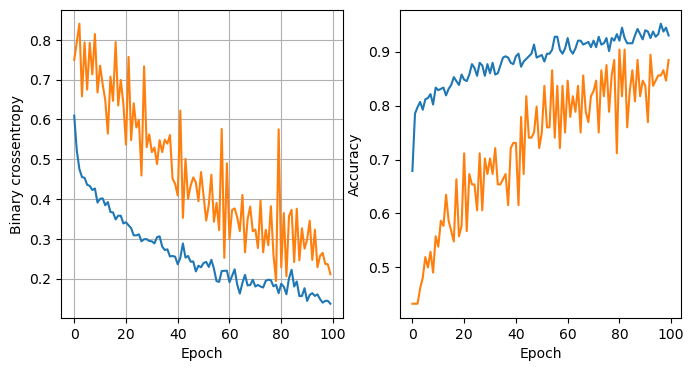

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7256 - loss: 1.6176
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
64 nodes , dropout 0.2, lr 0.005, batch size 64


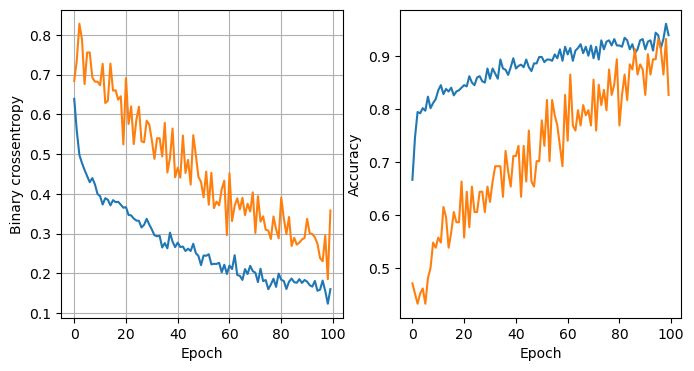

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7488 - loss: 1.3721
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
64 nodes , dropout 0.2, lr 0.005, batch size 128


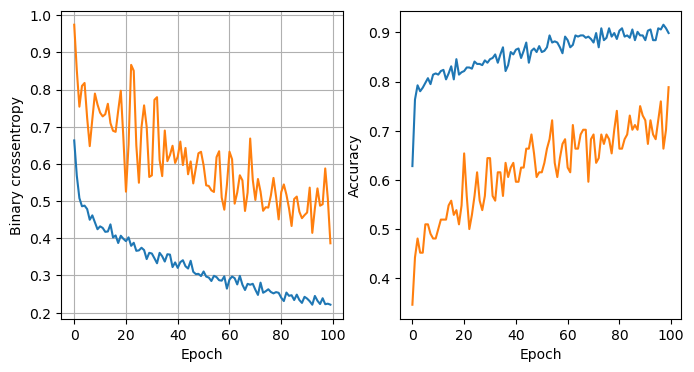

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7583 - loss: 0.9892  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
64 nodes , dropout 0.2, lr 0.001, batch size 32


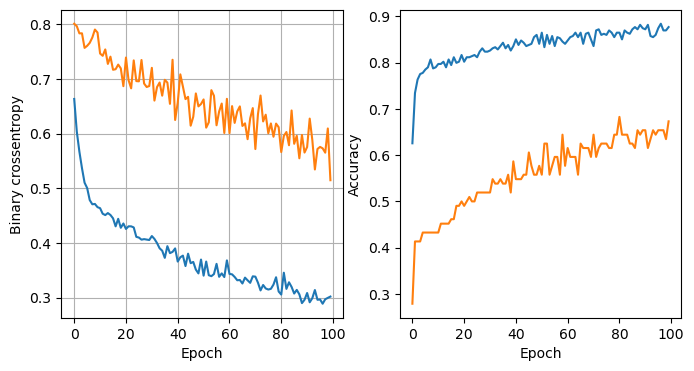

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7604 - loss: 0.7497
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
64 nodes , dropout 0.2, lr 0.001, batch size 64


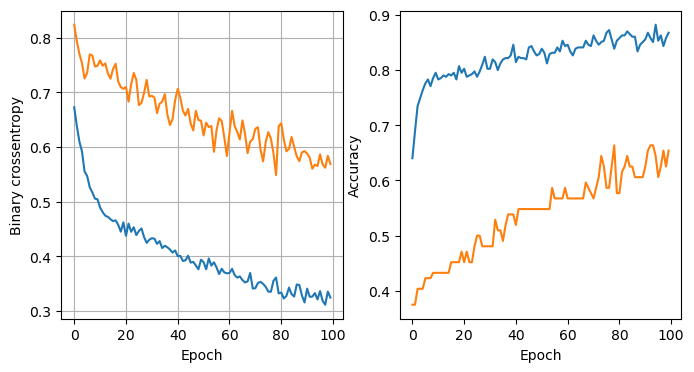

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7657 - loss: 0.6696
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
64 nodes , dropout 0.2, lr 0.001, batch size 128


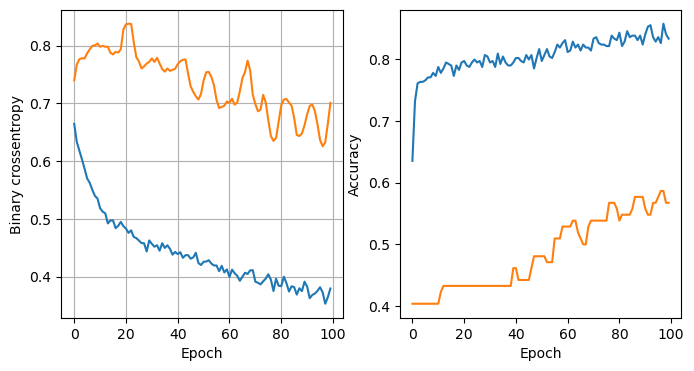

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7752 - loss: 0.6053
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [15]:
least_val_loss = float('inf')
least_loss_model = None
epochs = 100
for num_nodes in [16 , 32 , 64]:
  for dropout_prob in [0, 0.2]:
    for lr in [0.1 , 0.005 , 0.001]:
      for batch_size in [32 , 64 , 128]:
        print(f'{num_nodes} nodes , dropout {dropout_prob}, lr {lr}, batch size {batch_size}')
        model, history = train_model(x_train, y_train, num_nodes, dropout_prob, lr, batch_size, epochs)
        plot_history(history)
        val_loss = model.evaluate(x_valid, y_valid)[0]
        y_pred = model.predict(x_test)
        if val_loss < least_val_loss:
          least_val_loss = val_loss
          least_loss_model = model

In [16]:
least_loss_model.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_48 (Dense)                │ (None, 16)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,445 (5.65 KB)

 Trainable params: 481 (1.88 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 964 (3.77 KB)

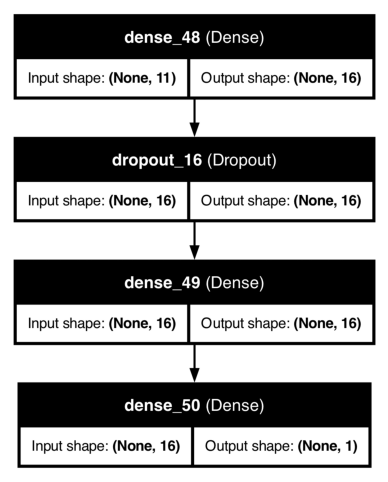

In [17]:
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
from PIL import Image

plot_model(
    least_loss_model,
    to_file='model_architecture.png',
    show_shapes=True,
    show_layer_names=True
)

img = Image.open('model_architecture.png')
plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.axis('off')
plt.show()

In [18]:
least_loss_model.predict(x_test)
y_pred = (y_pred > 0.5).astype(int).reshape(-1,)
y_pred

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


array([1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1])

In [19]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.91      0.54      0.68        39
           1       0.82      0.98      0.89        84

    accuracy                           0.84       123
   macro avg       0.87      0.76      0.78       123
weighted avg       0.85      0.84      0.82       123



Testing

In [21]:
test = pd.read_csv('test.csv')

In [22]:
test.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban


In [23]:
test = test.drop('Loan_ID', axis=1)

test['Dependents'] = test['Dependents'].replace('3+', 3)
test['Dependents'] = test['Dependents'].fillna(0)
test['Dependents'] = test['Dependents'].astype(int)

test['LoanAmount'] = test['LoanAmount'].fillna(round(df['LoanAmount'].mean()))

test['Loan_Amount_Term'] = test['Loan_Amount_Term'].fillna(round(df['Loan_Amount_Term'].mean()))
test['Credit_History'] = test['Credit_History'].fillna(round(df['Credit_History'].mean()))

test['Gender'] = (test['Gender']=='Male').astype(int)
test['Married'] = (test['Married']=='Yes').astype(int)
test['Education'] = (test['Education']=='Graduate').astype(int)
test['Self_Employed'] = (test['Self_Employed']=='Yes').astype(int)
test['Property_Area'] = test['Property_Area'].map({
    'Urban': 1,
    'Semiurban': 2,
    'Rural': 3
})

In [24]:
test, x_test, y_test = scale_dataset(test, oversample=False)

In [25]:
test.shape

(367, 11)

In [26]:
y_pred = least_loss_model.predict(test)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step


In [27]:
y_pred[:20]

array([[0.7879542 ],
       [0.8546357 ],
       [0.71194077],
       [0.94133544],
       [0.8001364 ],
       [0.6162669 ],
       [0.7627627 ],
       [0.05555035],
       [0.73993266],
       [0.53966266],
       [0.76695466],
       [0.6806599 ],
       [0.93354446],
       [0.05494597],
       [0.54976577],
       [0.7266417 ],
       [0.7264765 ],
       [0.8608493 ],
       [0.29878172],
       [0.65120876]], dtype=float32)

In [28]:
y_pred = (y_pred > 0.5).astype(int).reshape(-1,)
y_pred

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1,

In [29]:
test_df = pd.read_csv('test.csv')
pred_df = pd.DataFrame({
    'Loan_ID': test_df['Loan_ID'].values,
    'Loan_Status': y_pred
})

In [30]:
pred_df

,Loan_ID,Loan_Status
0,LP001015,1
1,LP001022,1
2,LP001031,1
3,LP001035,1
4,LP001051,1
...,...,...
362,LP002971,1
363,LP002975,1
364,LP002980,1
365,LP002986,0
